## Abstract

In this notebook, we create hexagons for a network file with the format .xml.gz. 

The steps are as follows:
1. Load the network.xml.gz file
2. Create a gdf out of it.
3. Implement the hexagons on the gdf level, adding another column "hexagon", numbered 1 - n for a city. 
4. Visualize the hexagons for different hexagon sizes.
5. Save the gdfs for hexagons with different sizes. 

In [96]:
import network_io as nio
import geopandas as gpd
import pandas as pd
import gzip
import xml.etree.ElementTree as ET
from shapely.geometry import LineString
import fiona
import matplotlib.pyplot as plt
import gzip
import xml.etree.ElementTree as ET
from shapely.geometry import LineString, Polygon
import shapely.geometry as sgeo
import network_io as nio


In [97]:
matsim_output_file_path = r"C:\Users\nktba\OneDrive\Desktop\paris_1pct_network.xml.gz"
administrative_boundary_json_path = r"C:\Users\nktba\Downloads\districts_paris.geojson"

#matsim_output_file_path = r"C:\Users\nktba\Downloads\augsburg_network.xml.gz"
#administrative_boundary_json_path = r"C:\Users\nktba\city_data\Augsburg.json"

In [104]:
nodes_dict = nio.parse_nodes(matsim_output_file_path)
df_edges = nio.parse_edges(matsim_output_file_path, nodes_dict)
gdf_edges = gpd.GeoDataFrame(df_edges, geometry='geometry', crs='EPSG:2154')
if gdf_edges.crs != "EPSG:25832":
    gdf_edges = gdf_edges.to_crs(epsg=25832)

In [105]:
districts_gdf = gpd.read_file(administrative_boundary_json_path)
# Ensure the data is in the correct CRS (EPSG:25832)
if districts_gdf.crs != "EPSG:25832":
    districts_gdf = districts_gdf.to_crs(epsg=25832)


In [106]:
# --- Step 3: Spatial join to find districts overlapping each edge ---
# Using 'intersects' to join edges with the district polygons
gdf_edges_with_districts = gpd.sjoin(gdf_edges, districts_gdf, how='left', predicate='intersects')

# --- Step 4: Group by edge and aggregate the district names ---
# Assuming the district name or attribute is in the column 'c_ar'
gdf_edges_with_districts = gdf_edges_with_districts.groupby('id').agg({
    'from': 'first',
    'to': 'first',
    'length': 'first',
    'freespeed': 'first',
    'capacity': 'first',
    'permlanes': 'first',
    'oneway': 'first',
    'modes': 'first',
    'geometry': 'first',
    'c_ar': lambda x: list(x.dropna())
}).reset_index()

# Rename the aggregated column to 'district'
gdf_edges_with_districts.rename(columns={'c_ar': 'district'}, inplace=True)

# Convert freespeed and capacity to numeric values
gdf_edges_with_districts['freespeed'] = pd.to_numeric(gdf_edges_with_districts['freespeed'], errors='coerce')
gdf_edges_with_districts['capacity'] = pd.to_numeric(gdf_edges_with_districts['capacity'], errors='coerce')

# Create a GeoDataFrame with the results
gdf_edges_with_districts = gpd.GeoDataFrame(gdf_edges_with_districts, geometry='geometry', crs='EPSG:25832')

In [101]:
def generate_hexagon_grid_for_polygon(polygon, hexagon_size, projection='EPSG:25832'):
    """
    Generates a hexagonal grid that fits within a given polygon.

    Parameters:
        polygon (shapely.geometry.Polygon): The polygon to clip the grid to.
        hexagon_size (float): Size of the hexagons (distance from center to vertex).
        projection (str): CRS of the polygon and output grid.
    
    Returns:
        GeoDataFrame: A GeoDataFrame containing hexagons clipped to the polygon, with a unique grid_id.
    """
    # Create a GeoDataFrame for the input polygon
    poly_gdf = gpd.GeoDataFrame({'geometry': [polygon]}, crs=projection)
    
    # Get bounding box of the polygon
    xmin, ymin, xmax, ymax = poly_gdf.total_bounds

    # Calculate the vertical spacing factor (height of hexagon is 2 * hexagon_size)
    # The distance from center to a vertex is hexagon_size, so the vertical distance between centers is hexagon_size * 1.5.
    # But here we use sin(60°) to compute the vertical offset for vertices.
    a = np.sin(np.pi / 3)  # Height factor of a hexagon
    cols = np.arange(np.floor(xmin), np.ceil(xmax), 3 * hexagon_size)
    rows = np.arange(np.floor(ymin) / a, np.ceil(ymax) / a, hexagon_size)

    # Generate hexagons
    hexagons = []
    for x in cols:
        for i, y in enumerate(rows):
            if i % 2 == 0:
                x0 = x
            else:
                x0 = x + 1.5 * hexagon_size

            hexagons.append(sgeo.Polygon([
                (x0, y * a),
                (x0 + hexagon_size, y * a),
                (x0 + (1.5 * hexagon_size), (y + hexagon_size) * a),
                (x0 + hexagon_size, (y + (2 * hexagon_size)) * a),
                (x0, (y + (2 * hexagon_size)) * a),
                (x0 - (0.5 * hexagon_size), (y + hexagon_size) * a),
            ]))
    
    # Convert list of hexagons into a GeoDataFrame
    grid = gpd.GeoDataFrame({'geometry': hexagons}, crs=projection)
    # Clip the grid to the input polygon (retain only portions within the polygon)
    grid_clipped = gpd.clip(grid, poly_gdf)
    # Create a unique identifier for each hexagon
    grid_clipped = grid_clipped.reset_index(drop=True)
    grid_clipped['grid_id'] = grid_clipped.index
    return grid_clipped


Total number of hexagons created: 203
Number of hexagons in multiple districts: 81

Edge Statistics:
Total number of edges: 31635
Number of edges in multiple hexagons: 3489
Number of edges in multiple districts: 16437


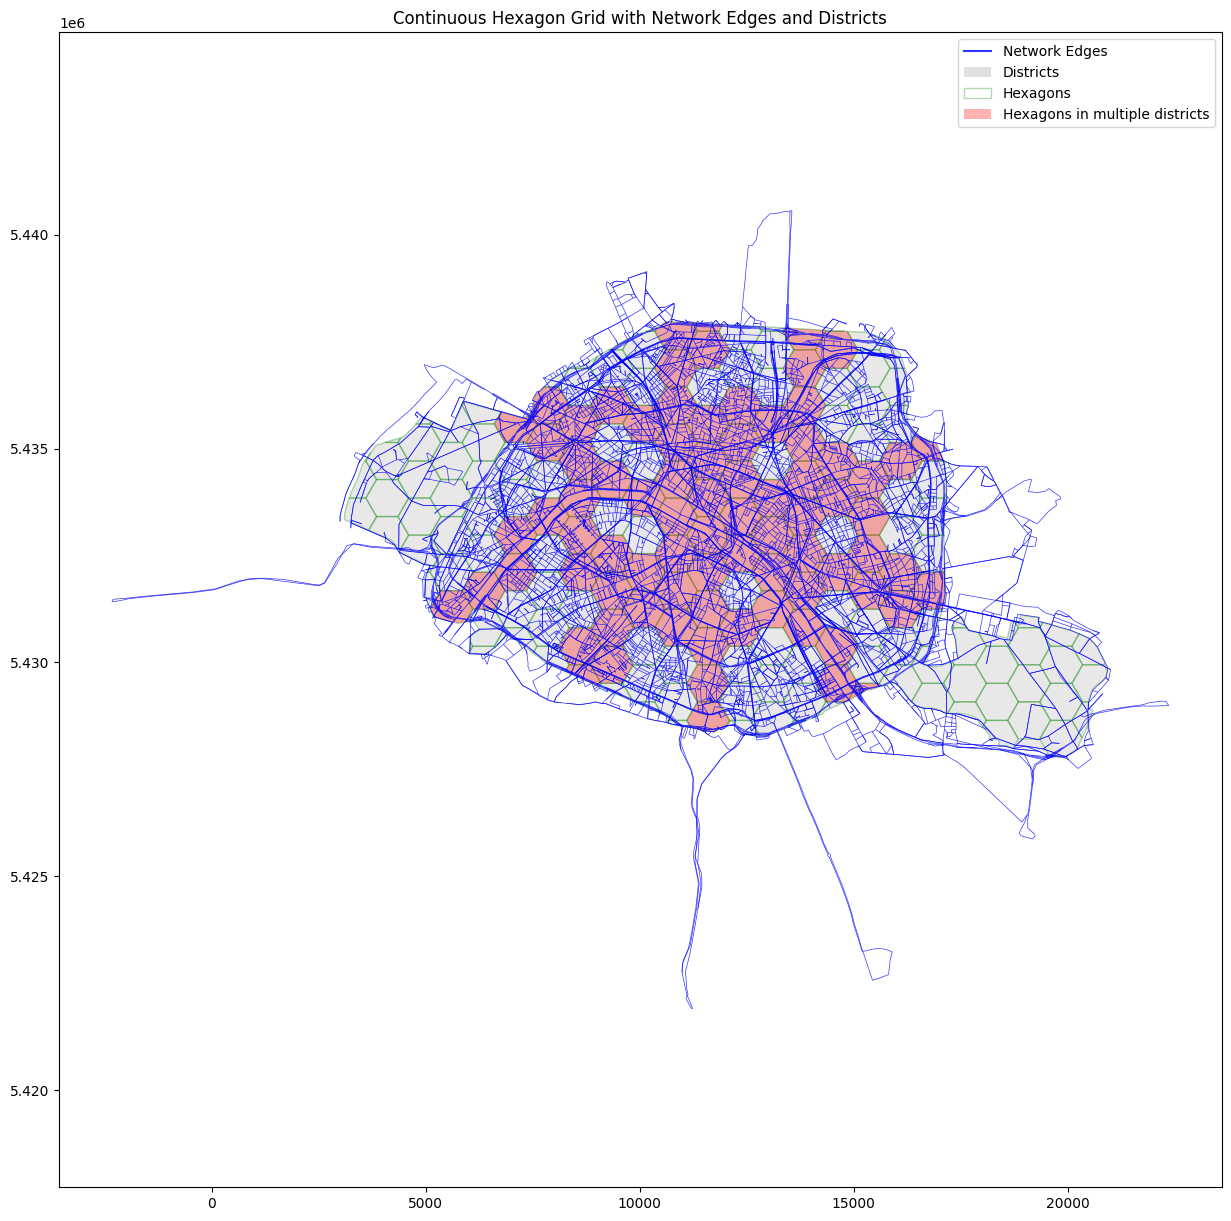

In [107]:
# First, get the outer boundary of the entire region
region_boundary = districts_gdf.union_all()

# Create a single continuous hexagon grid for the entire region
hexagon_size = 500  # Size in meters for EPSG:25832
hexagon_grid_all = generate_hexagon_grid_for_polygon(region_boundary, hexagon_size, projection='EPSG:25832')

# Add district information to each hexagon
def get_intersecting_districts(hex_geom):
    intersecting_districts = []
    for idx, row in districts_gdf.iterrows():
        if hex_geom.intersects(row['geometry']):
            district_id = row.get('district_name', idx)
            intersecting_districts.append(district_id)
    return intersecting_districts

hexagon_grid_all['districts'] = hexagon_grid_all['geometry'].apply(get_intersecting_districts)

print(f"Total number of hexagons created: {len(hexagon_grid_all)}")
print(f"Number of hexagons in multiple districts: {len(hexagon_grid_all[hexagon_grid_all['districts'].apply(lambda x: len(x) >= 2)])}")

# Spatial join to assign each edge the hexagon(s) it falls into
gdf_edges_with_hex = gpd.sjoin(gdf_edges_with_districts, hexagon_grid_all, how='left', predicate='intersects')

# Group by edge 'id' and aggregate the hexagon IDs into a list
gdf_edges_with_hex = gdf_edges_with_hex.groupby('id').agg({
    'from': 'first',
    'to': 'first',
    'length': 'first',
    'freespeed': 'first',
    'capacity': 'first',
    'permlanes': 'first',
    'oneway': 'first',
    'modes': 'first',
    'geometry': 'first',
    'grid_id': lambda x: list(x.dropna()),
    'districts': lambda x: list(set([d for dist_list in x.dropna() for d in dist_list]))  # Aggregate unique districts
}).reset_index()

# Rename the aggregated column
gdf_edges_with_hex.rename(columns={'grid_id': 'hexagon'}, inplace=True)

# Print some statistics
print("\nEdge Statistics:")
print(f"Total number of edges: {len(gdf_edges_with_hex)}")
print(f"Number of edges in multiple hexagons: {len(gdf_edges_with_hex[gdf_edges_with_hex['hexagon'].apply(lambda x: len(x) >= 2)])}")
print(f"Number of edges in multiple districts: {len(gdf_edges_with_hex[gdf_edges_with_hex['districts'].apply(lambda x: len(x) >= 2)])}")

# Create a better visualization with proper legend handling
fig, ax = plt.subplots(figsize=(15, 15))

# Plot edges first (in the background)
gdf_edges_with_districts.plot(ax=ax, color='blue', alpha=0.8, linewidth=0.5, label='Network Edges')

# Plot districts
districts_gdf.plot(ax=ax, color='lightgray', alpha=0.5, label='Districts')

# Plot all hexagons
hexagon_grid_all.plot(ax=ax, color='none', edgecolor='green', alpha=0.3, label='Hexagons')

# Highlight hexagons in multiple districts
hexagon_grid_all[hexagon_grid_all['districts'].apply(lambda x: len(x) >= 2)].plot(
    ax=ax, color='red', alpha=0.3, label='Hexagons in multiple districts'
)

# Add legend with explicit handles
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Line2D([0], [0], color='blue', alpha=0.8, label='Network Edges'),
    Patch(facecolor='lightgray', alpha=0.7, label='Districts'),
    Patch(facecolor='none', edgecolor='green', alpha=0.3, label='Hexagons'),
    Patch(facecolor='red', alpha=0.3, label='Hexagons in multiple districts')
]

ax.legend(handles=legend_elements)
plt.title('Continuous Hexagon Grid with Network Edges and Districts')
plt.axis('equal')
plt.show()

In [77]:
import geopandas as gpd

def multipolygon_to_polygon(geom):
    # If the geometry is a MultiPolygon, choose the polygon with the largest area.
    if geom.geom_type == "MultiPolygon":
        return max(geom.geoms, key=lambda p: p.area)
    return geom

# Read the original GeoJSON file (assumed to be in EPSG:25832)
gdf = gpd.read_file(r"C:\Users\nktba\city_data\Augsburg.json")

# Convert any MultiPolygon geometries to Polygon
gdf["geometry"] = gdf["geometry"].apply(multipolygon_to_polygon)

# Compute the surface area and perimeter (ensure the CRS units are in meters)
gdf["surface"] = gdf.geometry.area
gdf["perimetre"] = gdf.geometry.length

# Assign a sequential district number (c_ar)
gdf["c_ar"] = range(1, len(gdf) + 1)

# Keep only the desired columns
district_new = gdf[["c_ar", "surface", "perimetre", "geometry"]]
